## 📦 [데이터셋] 전자상거래 배송 데이터 (Customer Analytics)

본 데이터셋은 국제 전자상거래 업체의 고객 데이터로, **제품 배송의 정시 도착 여부**를 분석하고 예측하기 위한 목적으로 구성되었습니다.

### 1. 타겟 변수 (Target Variable)
* **Reached.on.Time_Y.N**: 제품의 정시 도착 여부
    * **1**: 지연 도착 (Delayed)
    * **0**: 정시 도착 (On Time)

---

### 2. 데이터 컬럼 상세 설명 (Features)

| 컬럼명 | 설명 | 데이터 타입 | 비고 (Perspective) |
| :--- | :--- | :--- | :--- |
| **ID** | 고객 고유 식별 번호 | Integer | 예측 모델 구축 시 제거 대상 |
| **Warehouse_block** | 창고 구역 (A, B, C, D, E) | Object | 구역별 물류 부하 및 병목 현상 확인 |
| **Mode_of_Shipment** | 배송 수단 (Ship, Flight, Road) | Object | 수단별 지연율(지연 비중) 분석의 핵심 |
| **Customer_care_calls** | 고객 센터 문의 전화 횟수 | Integer | 배송 지연에 따른 고객 불만 척도 |
| **Customer_rating** | 고객 만족도 점수 (1~5) | Integer | 지연 여부와 만족도의 상관관계 분석 |
| **Cost_of_the_Product** | 제품 가격 (USD) | Integer | 고가 제품의 우선 배송 여부 확인 |
| **Prior_purchases** | 이전 구매 횟수 | Integer | 충성 고객 대상 배송 서비스 수준 확인 |
| **Product_importance** | 제품 중요도 (low, med, high) | Object | 중요도에 따른 배송 지연 차이 존재 여부 |
| **Gender** | 고객 성별 (F, M) | Object | 성별에 따른 구매 패턴 차이 확인 |
| **Discount_offered** | 할인 금액 | Integer | **핵심 가설:** 할인 폭이 크면 주문 폭주로 지연 가능성 높음 |
| **Weight_in_gms** | 제품 무게 (g) | Integer | 무게에 따른 배송 수단 제한 및 지연 영향 |

---

### 3. 분석 전략 (Initial Strategy)

1. **데이터 정제:** ID 컬럼 삭제 및 범주형 변수(Warehouse, Mode 등) 수치화.
2. **핵심 가설 검증:** - 할인(`Discount_offered`)과 배송 지연(`1`)의 상관관계 분석.
   - 제품 무게(`Weight_in_gms`)가 배송 수단별 지연에 미치는 영향 분석.
3. **성능 지표:** 모델의 예측 성능은 **ROC-AUC** 점수를 기준으로 평가함.

### 0. 데이터 불러오기, 기본 코드

In [ ]:
# [0] 시스템 기초 설정 및 시각화 환경 구축
import os
import platform
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 무시 및 한글 폰트 설정 (시각화 가독성 확보)
warnings.filterwarnings('ignore')
if platform.system() == 'Darwin': 
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': 
    plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# [1] 데이터 전처리 및 구조 설계 도구
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder

# [2] 머신러닝 알고리즘 (정예 라인업)
# 2-1. 선형 및 트리 기반 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

# 2-2. 고성능 부스팅 모델
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# [3] 시스템 성능 검증 지표
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report
)

print("✅ 준비 완료")

✅ 준비 완료


In [17]:
HOME = os.getcwd()
HOME

'c:\\Users\\min2m\\github\\project\\E-commerce\\KHM'

In [18]:
Train = pd.read_csv(os.path.join(HOME, 'data','Train.csv'))

### 1. 검증용 데이터 분리

In [19]:
# 1. stratify 옵션을 써서 정답(Reached.on.Time_Y.N) 비율을 유지하며 8:2로 나눕니다.
# 이 함수는 내부적으로 데이터를 랜덤하게 섞어주기 때문에 sample을 따로 안 써도 됩니다.
part1, part2 = train_test_split(Train, 
                                test_size=0.2, 
                                random_state=42, 
                                stratify=Train['Reached.on.Time_Y.N'])

# 2. 각각 파일로 저장
part1.to_csv('data/train_df.csv', index=False)
part2.to_csv('data/test_df.csv', index=False)

print("데이터 분할 및 저장 완료!")
print(f"학습용: {part1.shape}, 테스트용: {part2.shape}")

데이터 분할 및 저장 완료!
학습용: (8799, 12), 테스트용: (2200, 12)


In [40]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

train_df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,7921,D,Road,4,1,261,2,medium,F,9,4158,0
1,1530,F,Ship,3,3,162,2,low,F,26,1659,1
2,10522,B,Ship,3,2,221,2,medium,M,9,4466,0
3,9559,D,Ship,3,5,157,4,medium,F,2,4640,0
4,969,A,Flight,2,5,272,2,low,M,24,3638,1


In [21]:
# 원본 비율
print(Train['Reached.on.Time_Y.N'].value_counts(normalize=True))

# 학습용 비율 (part1)
print(train_df['Reached.on.Time_Y.N'].value_counts(normalize=True))

# 테스트용 비율 (part2)
print(test_df['Reached.on.Time_Y.N'].value_counts(normalize=True))

Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64
Reached.on.Time_Y.N
1    0.596659
0    0.403341
Name: proportion, dtype: float64
Reached.on.Time_Y.N
1    0.596818
0    0.403182
Name: proportion, dtype: float64


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
 11  Reached.on.Time_Y.N  8799 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 825.0+ KB


In [23]:
train_df['Reached.on.Time_Y.N'].value_counts(normalize=True) * 100

Reached.on.Time_Y.N
1    59.665871
0    40.334129
Name: proportion, dtype: float64

### 2. 데이터 확인

In [26]:
# [1-1] 전체적인 구조와 결측치 확인
print("--- 🩺 데이터 기본 정보 ---")
print(train_df.info())

# [1-2] 수치형 데이터의 통계적 분포 (평균, 최소/최대 등)
print("\n--- 📊 수치형 데이터 요약 통계 ---")
display(train_df.describe())

--- 🩺 데이터 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
 11  Reached.on.Time_Y.N  8799 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 825.0+ KB
None

--- 📊 수치형 데이터 요약 통계 ---


,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000
mean,5474.369815,4.049096,2.997386,210.230367,3.581998,13.366974,3631.227867,0.596659
std,3173.326150,1.138649,1.411194,48.051317,1.532722,16.147015,1634.180615,0.490596
min,1.000000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2713.500000,3.000000,2.000000,170.000000,3.000000,4.000000,1838.000000,0.000000
50%,5470.000000,4.000000,3.000000,214.000000,3.000000,7.000000,4140.000000,1.000000
75%,8201.500000,5.000000,4.000000,251.000000,4.000000,10.000000,5045.000000,1.000000
max,10999.000000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [27]:
# 범주형 변수 분석 : 글자로 된 변수들은 '개수'와 '지연율'을 보는 게 핵심
# 반복되는 분석은 반복문(for)으로 깔끔하게!
cat_features = ['Warehouse_block', 'Mode_of_Shipment', 'Gender', 'Product_importance']

for col in cat_features:
    print(f"\n🔍 [{col}] 컬럼 상세 분석")
    # 1. 개수 확인
    print(train_df[col].value_counts())
    # 2. 지연율 확인 (상관관계 파악)
    display(train_df.groupby(col)['Reached.on.Time_Y.N'].mean().sort_values(ascending=False))


🔍 [Warehouse_block] 컬럼 상세 분석
Warehouse_block
F    2910
B    1487
D    1470
A    1468
C    1464
Name: count, dtype: int64


Warehouse_block
D    0.608163
F    0.598282
B    0.596503
A    0.594687
C    0.584016
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Mode_of_Shipment] 컬럼 상세 분석
Mode_of_Shipment
Ship      5981
Flight    1420
Road      1398
Name: count, dtype: int64


Mode_of_Shipment
Flight    0.604225
Ship      0.597057
Road      0.587268
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Gender] 컬럼 상세 분석
Gender
F    4475
M    4324
Name: count, dtype: int64


Gender
M    0.599214
F    0.594190
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Product_importance] 컬럼 상세 분석
Product_importance
low       4214
medium    3817
high       768
Name: count, dtype: int64


Product_importance
high      0.648438
low       0.597532
medium    0.585276
Name: Reached.on.Time_Y.N, dtype: float64

> Product_importance
* XGBoost 모델이 이 변수를 중요하게 쓰겠지만, high 데이터의 개수가 768개로 적은 편
* 768개가 특정 창고(Warehouse_block)에 몰려있는지 확인 후 -> 파생변수 만들지 여부 정하기

> Gender --> drop (+ID)

> Mode_of_Shipment
* 배(Ship), 비행기(Flight), 도로(Road)의 지연율이 거의 비슷(0.58~0.60).
* **'배송 수단 + 무게?'** 등을 조합한 파생변수 만들지 여부 정하기

> Warehouse_block
* F구역이 데이터는 압도적으로 많지만(2,910개), 지연율은 모든 구역이 58~60%로 일정
* 특정 구역이나 수단의 고질적 문제라기보다, 전체적인 물류 프로세스의 공통적인 지연 요소가 있을 것으로 판단됨.

In [30]:
# "중요도(high)는 특정 창고에 몰려있을까?"
# 창고별 제품 중요도 분포
importance_warehouse = pd.crosstab(train_df['Warehouse_block'], train_df['Product_importance'])
print("--- 🏢 창고별 중요도 제품 건수 ---")
print(importance_warehouse)

# 지연율까지 같이 보고 싶다면?
importance_delay = train_df.pivot_table(index='Warehouse_block', 
                                     columns='Product_importance', 
                                     values='Reached.on.Time_Y.N', 
                                     aggfunc='mean')
print("\n--- 🚨 창고x중요도별 지연율 (%) ---")
display(importance_delay * 100)

--- 🏢 창고별 중요도 제품 건수 ---
Product_importance  high   low  medium
Warehouse_block                       
A                    127   734     607
B                    124   684     679
C                    141   695     628
D                    135   703     632
F                    241  1398    1271

--- 🚨 창고x중요도별 지연율 (%) ---


Product_importance,high,low,medium
Warehouse_block,,,
A,70.078740,60.217984,56.342669
B,66.129032,57.163743,60.972018
C,63.120567,61.007194,54.458599
D,66.666667,60.455192,59.968354
F,61.410788,59.799714,59.559402


> 창고 A는 중요도 high 제품 지연율이 70.08% / 유독 중요한 물건을 다룰 때 병목현상이 심하게 일어남 
* 근데 데이터 개수 127개 >> 파생변수는 만들지 않는 게 더 나은 선택 (일반화 하기에 너무 작은 표본)
* XGBoost 돌리면 알아서 처리

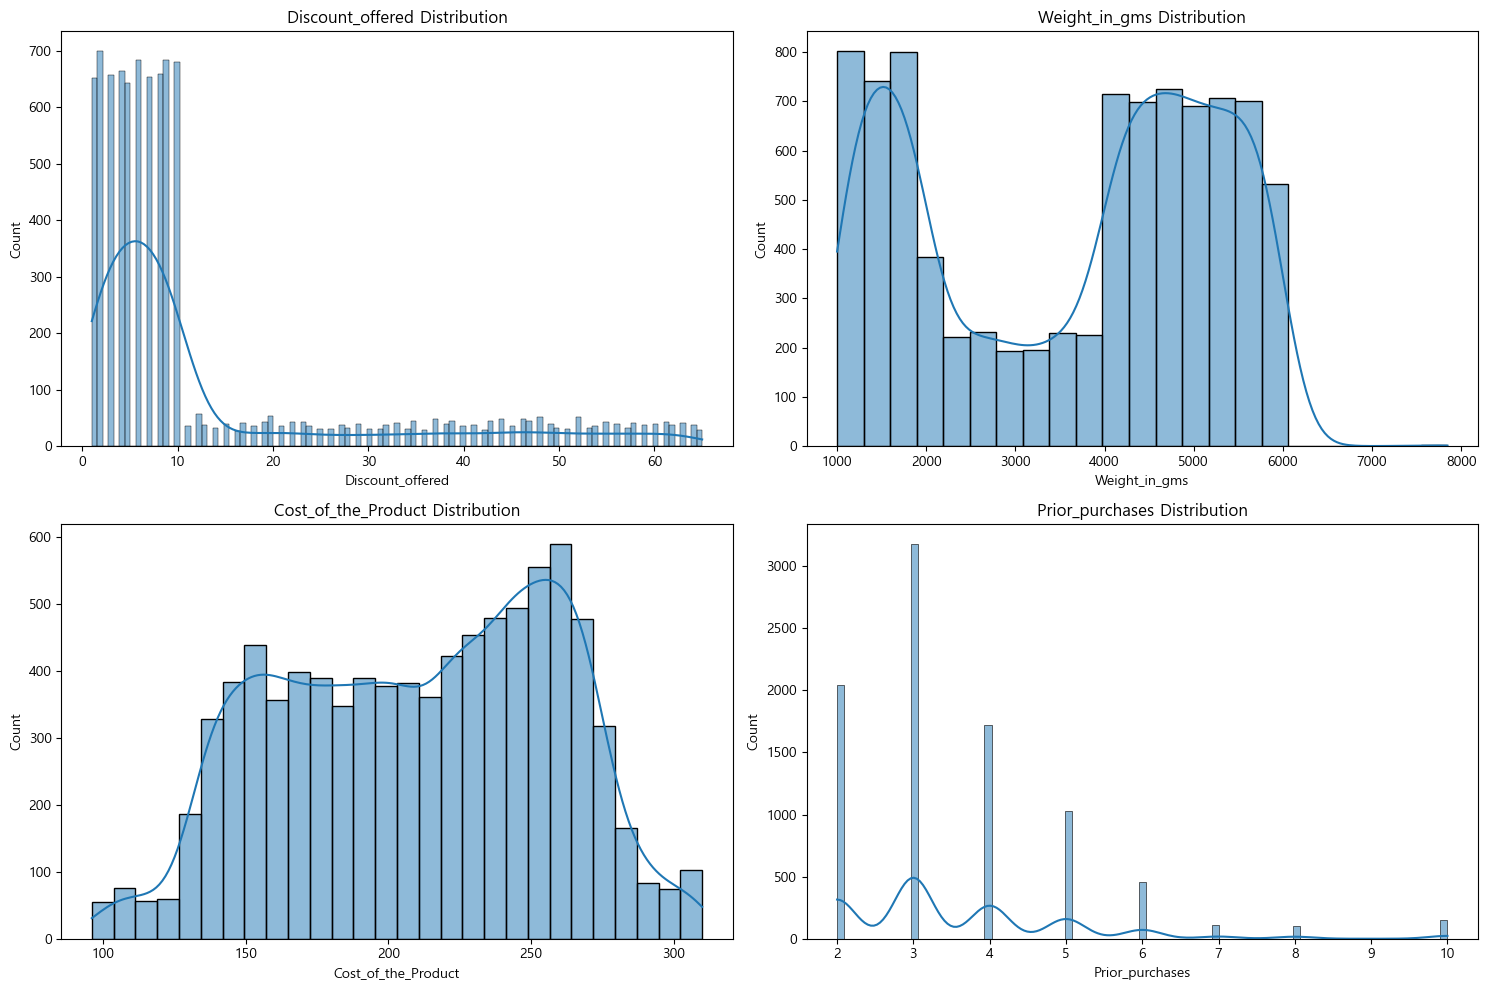

In [32]:
# 숫자형 변수 분석 : 분포 + 이상치 확인
num_features = ['Discount_offered', 'Weight_in_gms', 'Cost_of_the_Product', 'Prior_purchases']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

> Discount_offered (할인) - ⚠️ 10.5 (지니계수가 가장 적은 게 10.5라고 계산함)
* $10.5$달러 초과의 고액 할인은 주문 폭주를 일으켜 과부하되는 듯

> Weight_in_gms (제품 무게) - 🚨 위험 구간 2~4kg
* 특정 무게 구간(2,000g~4,000g)에서 지연 데이터가 비정상적으로 많이 관찰
* 어중간한 2~4kg 무게가 포장이나 적재 시 가장 많이 지연되는 '데드 존(Dead Zone)'

*** 가설1 : 할인 품목이 2~4kg가 많지 않을까 하는 생각<br>
*** 가설2 : 가벼운것/무거운것보다 중간이 많으니까 어디 밀려났다가 한꺼번에 처리하지 않을까 하는 추측

> Cost_of_the_Product (제품 가격)
* 어느 한 곳에 쏠리지 않고 골고루 분포됨. 무게랑 같이 엮어서 **'무게 대비 가격(Value Density)'** 파생 변수를 만들기

> Prior_purchases(이전 구매 횟수)
* 3회 구매자가 가장 많고, 6회 이상부터는 데이터가 확 줄어듦
* 재구매 6회 이상 단골고객 패턴은 비슷하니, 모델이 헷갈리지 않게 하나로 묶어주기

> Weight_in_gms 가설 확인
* 가설1 : 할인 품목이 2~4kg가 많아서 지연<br>
* 가설2 : 가벼운것/무거운것보다 중간 무게가 많아서 물량이 많은만큼 지연

--- 💸 무게 구간별 할인액 통계 ---
                        mean  median  count
Weight_Group                               
1. Small (<2kg)    16.740340     8.0   2588
2. Medium (2-4kg)  32.887285    34.0   1455
3. Large (>4kg)     5.559504     6.0   4756

--- 📦 무게 구간별 물동량(건수) 비교 ---
Weight_Group
3. Large (>4kg)      54.051597
1. Small (<2kg)      29.412433
2. Medium (2-4kg)    16.535970
Name: proportion, dtype: float64


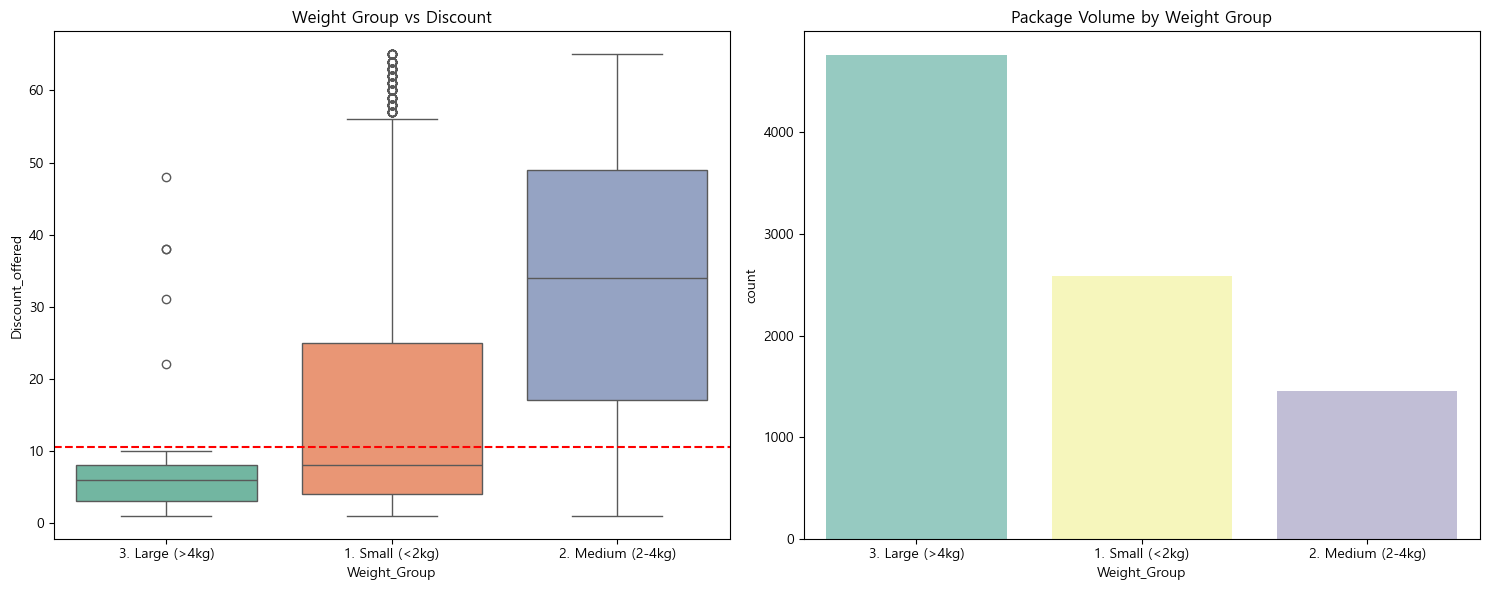

In [33]:
# [1] 무게 구간 나누기 (2~4kg를 집중적으로 보기 위함)
def categorize_weight(w):
    if w < 2000: return '1. Small (<2kg)'
    elif 2000 <= w <= 4000: return '2. Medium (2-4kg)'
    else: return '3. Large (>4kg)'

# 전처리 중인 데이터프레임(train_df)에 적용
train_df['Weight_Group'] = train_df['Weight_in_gms'].apply(categorize_weight)

# [2] 가설 1 확인: "2~4kg에 할인 품목이 몰려 있는가?"
# 무게 구간별 할인액(Discount_offered)의 평균과 중앙값 확인
discount_analysis = train_df.groupby('Weight_Group')['Discount_offered'].agg(['mean', 'median', 'count'])
print("--- 💸 무게 구간별 할인액 통계 ---")
print(discount_analysis)

# [3] 가설 2 확인: "2~4kg 물량이 압도적으로 많아서 밀리는가?"
# 위에서 구한 'count' 컬럼이 바로 물동량(Volume)
print("\n--- 📦 무게 구간별 물동량(건수) 비교 ---")
print(train_df['Weight_Group'].value_counts(normalize=True) * 100) # 퍼센트로 보기

# [4] 시각화로 한눈에 확인 (Boxplot + Countplot)
plt.figure(figsize=(15, 6))

# 왼쪽: 할인율 분포 (가설 1 검증)
plt.subplot(1, 2, 1)
sns.boxplot(data=train_df, x='Weight_Group', y='Discount_offered', palette='Set2')
plt.axhline(10.5, color='red', linestyle='--', label='High Discount Line')
plt.title('Weight Group vs Discount')

# 오른쪽: 물동량 확인 (가설 2 검증)
plt.subplot(1, 2, 2)
sns.countplot(data=train_df, x='Weight_Group', palette='Set3')
plt.title('Package Volume by Weight Group')

plt.tight_layout()
plt.show()

> 결과

**가설1** ⭕
* 2~4kg 그룹의 평균할인액 32.69 중앙값 34.0
* 다른 그룹(Small: 16.7달러, Large: 5.5달러)과 비교하면 압도적으로 높은 할인이 이 구간에 쏠림
* 기업이 가장 공격적으로 프로모션을 진행하는 '전략 상품군'이 바로 이 2~4kg 무게대에 집중되어 있다

**가설2** ❌
* 물동량 1위는 Large (>4kg) 그룹으로,53.9%
* Medium (2-4kg) 16.5% - 물량이 가장 적음
* 물량이 많아서 밀리는 게 아니라 '할인 폭이 너무 커서' 주문이 한꺼번에 몰리거나, 특별 관리가 필요해서 지연되는 '프로모션의 함정' 구간임

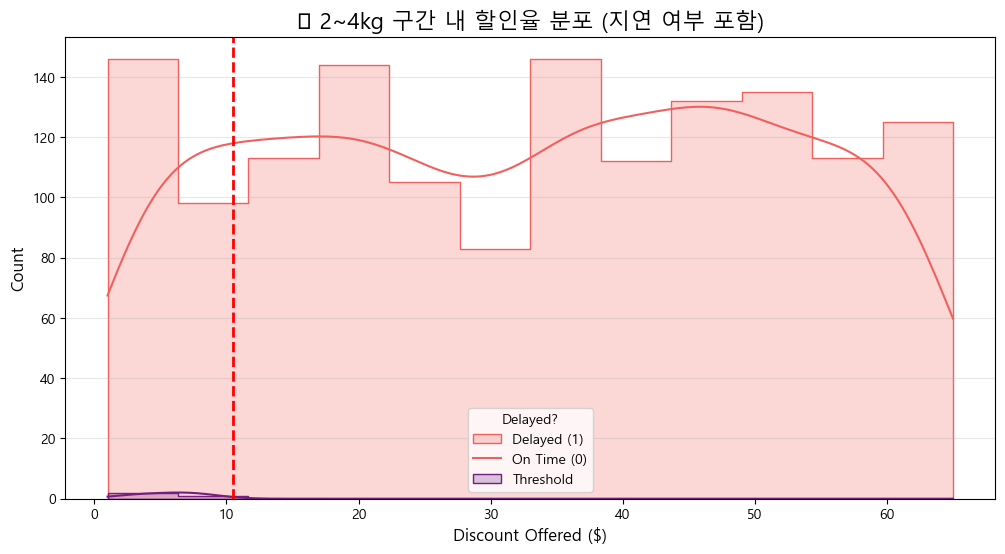

--- 📊 2~4kg 구간 심층 통계 ---
1. 전체 건수: 1455건
2. 10.5$ 초과 고액 할인 건수: 1228건
3. 고액 할인 비중: 🔥 84.4% 🔥


In [34]:
# [Section 2-6] 2~4kg 구간(Danger Zone) 내부의 할인율 분포 및 비중 확인

# 1. 2~4kg 데이터만 필터링
danger_weight_df = train_df[(train_df['Weight_in_gms'] >= 2000) & (train_df['Weight_in_gms'] <= 4000)]

# 2. 시각화 (지연 여부로 색깔 구분!)
plt.figure(figsize=(12, 6))
sns.histplot(data=danger_weight_df, x='Discount_offered', hue='Reached.on.Time_Y.N', 
             kde=True, palette='magma', element="step")

# 3. 10.5 선 긋기
plt.axvline(10.5, color='red', linestyle='--', linewidth=2, label='Magic Line: 10.5$')

plt.title('📦 2~4kg 구간 내 할인율 분포 (지연 여부 포함)', fontsize=16)
plt.xlabel('Discount Offered ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Delayed?', labels=['Delayed (1)', 'On Time (0)', 'Threshold'])
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. 수치 확인
total_cnt = len(danger_weight_df)
high_discount_cnt = len(danger_weight_df[danger_weight_df['Discount_offered'] > 10.5])
percentage = (high_discount_cnt / total_cnt) * 100 if total_cnt > 0 else 0

print(f"--- 📊 2~4kg 구간 심층 통계 ---")
print(f"1. 전체 건수: {total_cnt}건")
print(f"2. 10.5$ 초과 고액 할인 건수: {high_discount_cnt}건")
print(f"3. 고액 할인 비중: 🔥 {percentage:.1f}% 🔥") # 소수점 첫째자리까지 표시

> 무게(Weight)와 할인(Discount)의 관계

제품 무게 2,000g~4,000g 구간은 물동량 비중은 **16.5%**로 가장 낮지만, 평균 할인액은 32.69달러로 타 구간 대비 압도적으로 높음.

결론: 해당 구간의 높은 지연율은 '물량 과부하' 때문이 아니라, 고액 할인이 집중된 프로모션 상품들의 주문 처리 과정에서 발생하는 병목 현상이 주원인으로 분석됨.

전략: 따라서 Is_Danger_Weight 파생 변수는 단순히 무게를 보는 것이 아니라, **'고할인 전략 상품군'을 식별하는 대리 변수(Proxy Variable)**로서 강력한 예측력을 가지게 됨.

### 🛠️ 3. Feature Engineering (변수 생성 및 데이터 정제)

In [35]:
def prep(df):
    temp = df.copy()
    
    # 1. 파생 변수 생성 (가설 기반)
    temp['Is_High_Discount'] = (temp['Discount_offered'] > 10.5).astype(int)
    temp['Is_Danger_Weight'] = temp['Weight_in_gms'].between(2000, 4000).astype(int)
    temp['Value_Density'] = temp['Cost_of_the_Product'] / temp['Weight_in_gms']
    
    # 2. 수치화 및 순서형 인코딩
    temp['Prior_purchases'] = temp['Prior_purchases'].apply(lambda x: 6 if x >= 6 else x)
    mapping = {'low': 1, 'medium': 2, 'high': 3}
    if 'Product_importance' in temp.columns and temp['Product_importance'].dtype == 'object':
        temp['Product_importance'] = temp['Product_importance'].str.lower().map(mapping)
    
    # 3. 범주형 인코딩 (One-Hot Encoding으로 서열 방지)
    # Warehouse_block, Mode_of_Shipment만 독립적으로 분리
    temp = pd.get_dummies(temp, columns=['Warehouse_block', 'Mode_of_Shipment'])
            
    # 4. 불필요한 힌트 제거 (ID, Gender 등 제거)
    drop_cols = ['ID', 'Gender']
    temp = temp.drop(columns=[c for c in drop_cols if c in temp.columns])
    
    return temp

In [36]:
# [3] 실행 및 배치
target = 'Reached.on.Time_Y.N'

# 1. 원본(Train)이 아니라, 8:2로 쪼개진 '학습용 조각(train_df)'을 사용
# tr_p: train_processed / te_p: test_processed
tr_p = prep(train_df) 
te_p = prep(test_df)

# 2. 정제된 바구니에서 X, y 분리
X_train, y_train = tr_p.drop(columns=target), tr_p[target]
X_test, y_test = te_p.drop(columns=target), te_p[target]

print(f"✅ 시스템 최적화 완료")
print(f"학습용(train_df 기반): {X_train.shape}")
print(f"검증용(test_df 기반): {X_test.shape}")

✅ 시스템 최적화 완료
학습용(train_df 기반): (8799, 19)
검증용(test_df 기반): (2200, 18)


### 4. 모델링 및 검증

#### 4-1. 모델 선정
본 프로젝트는 단순 모델에서 복합 모델로 확장하는 보텀업(Bottom-Up) 방식을 채택했습니다. 데이터의 특성을 층층이 파악하여 최적의 성능을 낼 수 있는 구조를 설계했습니다.

모델을 설계하는 과정에서는 수동 튜닝(Manual Tuning)을 통해 모델의 작동 원리를 깊이 있게 파악했고, 동시에 AutoML(AutoGluon)을 벤치마킹 지표로 활용하여 우리가 도출한 모델이 객관적으로 얼마나 최상단에 도달했는지 검증하는 '성능 가이드라인'으로 삼았습니다.

> 단계적 모델 확장 (Bottom-Up) : 선형적->비선형적->집단지성->부스팅 방식
[모델 확장 단계]
* Linear Model (Logistic Regression): 변수와 종속변수 간의 기본적인 선형 관계를 파악하고 베이스라인 수립
* Non-Linear Model (Decision Tree): 데이터 내 비선형적 패턴 및 변수 간 상호작용 탐색
* Ensemble - Bagging (Random Forest): 모델의 분산을 줄여 과적합을 방지하고 일반화 성능 확보
* Ensemble - Boosting (XGBoost / LightGBM): 잔차(Residual) 수정을 통해 예측 정밀도를 극대화하는 최신 알고리즘 적용

> 성능 비교로 AutoML